In [134]:
#Importamos librerías
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import re

In [135]:
inv = pd.read_csv("inventario_central_v2_limpio.csv")
trx = pd.read_csv("transacciones_logistica_final_unificado.csv")
fb  = pd.read_csv("feedback_clientes_limpio.csv")

In [136]:
inv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2413 entries, 0 to 2412
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SKU_ID              2413 non-null   object 
 1   Categoria           2413 non-null   object 
 2   Stock_Actual        2413 non-null   float64
 3   Costo_Unitario_USD  2413 non-null   float64
 4   Punto_Reorden       2413 non-null   int64  
 5   Lead_Time_Dias      2413 non-null   float64
 6   Bodega_Origen       2413 non-null   object 
 7   Ultima_Revision     2413 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 150.9+ KB


In [137]:
# Función realizada por IA
def audit(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame({
        "nulos_%": (df.isna().mean() * 100).round(2),
        "tipo": df.dtypes.astype(str),
        "nulos_n": df.isna().sum()
    }).sort_values("nulos_%", ascending=False)
    return out


In [138]:
# Esta informanción es sacada del libro Storytelling with Data
ACCENT = "#1f77b4"   # énfasis
NEUTRAL = "#9aa0a6"  # contexto
RISK = "#d62728"     # alerta (poco uso)

plt.rcParams.update({
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.15,
    "axes.titleweight": "bold",
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

def barh_series(s, title, xlabel, highlight_last=True, fmt=None):
    s = s.sort_values(ascending=True)
    colors = [NEUTRAL] * len(s)
    if highlight_last and len(s) > 0:
        colors[-1] = ACCENT

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.barh(s.index.astype(str), s.values, color=colors)

    if fmt is not None:
        for i, v in enumerate(s.values):
            ax.text(v, i, f" {fmt(v)}", va="center", fontsize=9, color="#333")

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    plt.tight_layout()
    plt.show()

def kpi_tile(title, value_text, subtitle, color=ACCENT):
    # Tile compacto: sin “aire” y centrado
    fig, ax = plt.subplots(figsize=(6.5, 2.2))
    ax.axis("off")
    ax.text(0.5, 0.72, value_text, ha="center", va="center",
            fontsize=34, fontweight="bold", color=color, transform=ax.transAxes)
    ax.text(0.5, 0.28, subtitle, ha="center", va="center",
            fontsize=12, color="#333", transform=ax.transAxes)
    ax.set_title(title, pad=8)
    plt.tight_layout()
    plt.show()



  ### Unión estratégica

In [139]:
# Normalizar llaves
inv["SKU_ID"] = inv["SKU_ID"].astype(str).str.strip()
trx["SKU_ID"] = trx["SKU_ID"].astype(str).str.strip()
trx["Transaccion_ID"] = trx["Transaccion_ID"].astype(str).str.strip()
fb["Transaccion_ID"]  = fb["Transaccion_ID"].astype(str).str.strip()

print("Chequeo rápido de llaves")
print("SKUs únicos en trx:", trx["SKU_ID"].nunique())
print("SKUs únicos en inv:", inv["SKU_ID"].nunique())
print("Transacciones únicas en trx:", trx["Transaccion_ID"].nunique())
print("Transacciones únicas en fb:", fb["Transaccion_ID"].nunique())

Chequeo rápido de llaves
SKUs únicos en trx: 2886
SKUs únicos en inv: 2413
Transacciones únicas en trx: 9815
Transacciones únicas en fb: 3595


In [140]:
# Consolidar feedback a nivel Transaccion_ID (1 fila por transacción)
agg_map = {
    "Rating_Producto": "mean",
    "Rating_Logistica": "mean",
    "Satisfaccion_NPS": "mean",
    "Edad_Cliente": "mean",
}

if "Ticket_Soporte_Abierto" in fb.columns:
    ticket = fb["Ticket_Soporte_Abierto"].astype(str).str.strip().str.lower()
    fb["_Ticket_Soporte_bool"] = ticket.isin(["si", "sí", "s", "yes", "true", "1"])
    agg_map["_Ticket_Soporte_bool"] = "any"

fb_agg = fb.groupby("Transaccion_ID", as_index=False).agg(agg_map)

if "_Ticket_Soporte_bool" in fb_agg.columns:
    fb_agg = fb_agg.rename(columns={"_Ticket_Soporte_bool": "Ticket_Soporte_Abierto"})

print("Feedback agregado")
print("Filas fb original:", len(fb))
print("Filas fb_agg (1 por Transaccion_ID):", len(fb_agg))

Feedback agregado
Filas fb original: 4455
Filas fb_agg (1 por Transaccion_ID): 3595


In [141]:
# Join TRX + FB (a nivel transacción)
# Nota: conservar transacciones sin feedback, cambie how="left".
trx_fb = trx.merge(
    fb_agg,
    on="Transaccion_ID",
    how="inner",
    validate="many_to_one"  # muchas transacciones -> 1 fila de feedback agregado
)

print("== Join trx + fb_agg ==")
print("Filas trx:", len(trx))
print("Filas trx_fb (inner):", len(trx_fb))
print("Transacciones perdidas por no tener feedback:",
      trx["Transaccion_ID"].nunique() - trx_fb["Transaccion_ID"].nunique())

== Join trx + fb_agg ==
Filas trx: 9815
Filas trx_fb (inner): 3525
Transacciones perdidas por no tener feedback: 6290


In [142]:
# Dilema SKU Fantasma: decidir estrategia de unión con inventario
# Estrategia: LEFT join desde trx_fb hacia inv
# - Mantiene ventas aunque no exista SKU en inventario (fantasmas quedan con costo NaN)
# - Permite cuantificar cuántas ventas están "sin catálogo" y su impacto en margen
dataset = trx_fb.merge(
    inv,
    on="SKU_ID",
    how="left",
    validate="many_to_one"
)

print("Join trx_fb + inv (LEFT)")
print("Filas dataset:", len(dataset))
sku_fantasma_mask = dataset["Costo_Unitario"].isna() if "Costo_Unitario" in dataset.columns else dataset.filter(like="Costo").isna().any(axis=1)
sku_fantasma_count = int(sku_fantasma_mask.sum())
print("Ventas con SKU fantasma (sin match en inventario):", sku_fantasma_count)
print("Porcentaje SKU fantasma:", round(100 * sku_fantasma_count / len(dataset), 2), "%")

Join trx_fb + inv (LEFT)
Filas dataset: 3525
Ventas con SKU fantasma (sin match en inventario): 699
Porcentaje SKU fantasma: 19.83 %


In [143]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3525 entries, 0 to 3524
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Transaccion_ID          3525 non-null   object 
 1   SKU_ID                  3525 non-null   object 
 2   Fecha_Venta             3505 non-null   object 
 3   Cantidad_Vendida        3525 non-null   float64
 4   Precio_Venta_Final      3525 non-null   float64
 5   Costo_Envio             3525 non-null   float64
 6   Tiempo_Entrega_Real     3525 non-null   float64
 7   Estado_Envio            3525 non-null   object 
 8   Ciudad_Destino          3525 non-null   object 
 9   Canal_Venta             3525 non-null   object 
 10  Ciudad_Destino_norm     3525 non-null   object 
 11  Canal_Venta_norm        3525 non-null   object 
 12  Rating_Producto         3525 non-null   float64
 13  Rating_Logistica        3525 non-null   float64
 14  Satisfaccion_NPS        3525 non-null   

In [144]:
audit(dataset)

,nulos_%,tipo,nulos_n
Bodega_Origen,19.83,object,699
Categoria,19.83,object,699
Costo_Unitario_USD,19.83,float64,699
Stock_Actual,19.83,float64,699
Ultima_Revision,19.83,object,699
Lead_Time_Dias,19.83,float64,699
Punto_Reorden,19.83,float64,699
Fecha_Venta,0.57,object,20
Estado_Envio,0.00,object,0
Tiempo_Entrega_Real,0.00,float64,0


La razón para agrupar el feedback por Transaccion_ID es clara: el objetivo es evaluar cada transacción, no cada comentario del cliente; una misma compra puede tener múltiples comentarios, calificaciones o reclamos, y si se juntan esos registros directamente, esa venta se repetiría reiteradamente, creando una percepción errónea de ingresos, costos, entregas y calidad del servicio. Al concentrar todo el feedback en una sola fila por transacción —mediando las calificaciones y marcando solo si hubo soporte— se logra que cada fila represente una compra real con toda su información, permitiendo que los números, las comparaciones y las decisiones del negocio sean imparciales y auténticas.

### Feature Engineering (métricas derivadas reales)

In [145]:
# Normalizar columna de costo unitario
if "Costo_Unitario_USD" not in dataset.columns:
    if "Costo_Unitario" in dataset.columns:
        dataset = dataset.rename(columns={"Costo_Unitario": "Costo_Unitario_USD"})
    else:
        # Si no existe ninguna, se crea como NaN para no romper cálculos
        dataset["Costo_Unitario_USD"] = np.nan

# SKU fantasma = costo unitario inexistente (no match inventario)
dataset["SKU_Fantasma"] = dataset["Costo_Unitario_USD"].isna()

sku_fantasma_count = int(dataset["SKU_Fantasma"].sum())
print("Ventas con SKU fantasma:", sku_fantasma_count)
print("Porcentaje SKU fantasma:", round(100 * sku_fantasma_count / len(dataset), 2), "%")


Ventas con SKU fantasma: 699
Porcentaje SKU fantasma: 19.83 %


In [146]:
# Ingreso total por venta
dataset["Ingreso_Total"] = dataset["Cantidad_Vendida"] * dataset["Precio_Venta_Final"]

# Costo del producto vendido (si no hay costo, queda NaN)
dataset["Costo_Producto"] = dataset["Cantidad_Vendida"] * dataset["Costo_Unitario_USD"]

# Costo logístico total (si no existe, NaN)
dataset["Costo_Logistico"] = dataset["Costo_Envio"] if "Costo_Envio" in dataset.columns else np.nan

# Margen absoluto (USD)
dataset["Margen_Utilidad"] = dataset["Ingreso_Total"] - dataset["Costo_Producto"] - dataset["Costo_Logistico"]

# Margen porcentual
dataset["Margen_%"] = np.where(
    dataset["Ingreso_Total"] > 0,
    dataset["Margen_Utilidad"] / dataset["Ingreso_Total"],
    np.nan
)

# Quiebre de stock (si faltan columnas, NaN)
if {"Stock_Actual", "Cantidad_Vendida"}.issubset(dataset.columns):
    dataset["Stock_Insuficiente"] = dataset["Stock_Actual"] < dataset["Cantidad_Vendida"]
else:
    dataset["Stock_Insuficiente"] = np.nan

# Envío tardío
if {"Tiempo_Entrega_Real", "Lead_Time_Dias"}.issubset(dataset.columns):
    dataset["Entrega_Tardia"] = dataset["Tiempo_Entrega_Real"] > dataset["Lead_Time_Dias"]
else:
    dataset["Entrega_Tardia"] = np.nan

dataset["Riesgo_Operacion"] = np.where(
    (dataset["Entrega_Tardia"] == True) | (dataset["Stock_Insuficiente"] == True),
    "Alto",
    "Normal"
)


Estas variables se generan porque convierten una tabla operativa de ventas, envíos e inventario en un modelo económico y de riesgo del negocio, es decir, transforman datos aislados en información para medir rentabilidad, eficiencia y control.

Ingreso_Total se calcula para saber cuánto dinero genera realmente cada venta, ya que el precio unitario por sí solo no refleja el tamaño económico de la transacción; Costo_Producto permite cuantificar cuánto cuesta producir o adquirir lo que se vendió, lo que es indispensable para evaluar si una venta crea o destruye valor; Costo_Logístico se incluye porque el envío es parte del costo real de servir al cliente y puede convertir una venta aparentemente rentable en una pérdida; a partir de estos tres se calcula Margen_Utilidad, que es la métrica central que indica si una venta aporta o quita dinero al negocio, y Margen_%, que normaliza ese resultado para poder comparar productos y canales sin depender del volumen; el indicador SKU_Fantasma se crea para identificar explícitamente las ventas que no existen en el inventario y por tanto no tienen costo ni control, lo que permite separar el negocio visible del negocio oculto; Stock_Insuficiente detecta si se vendió más de lo que había disponible, revelando fallas en planeación o ejecución; Entrega_Tardia compara el tiempo real de entrega con el lead time esperado para medir incumplimientos logísticos; y finalmente Riesgo_Operacion integra estos dos últimos en una sola señal que marca las ventas con mayor probabilidad de generar reclamos, sobrecostos o pérdida de clientes, permitiendo priorizar acciones sobre los puntos más frágiles de la operación.

### Validación del dilema del SKU fantasma

In [147]:
print("\nDilema del SKU Fantasma")

total_ventas = len(dataset)
n_fantasmas = int(dataset["SKU_Fantasma"].sum())

print("Ventas totales:", total_ventas)
print("Ventas con SKU fantasma:", n_fantasmas)
print("Porcentaje sin inventario:", round(100 * n_fantasmas / total_ventas, 2), "%")

controlados = dataset[~dataset["SKU_Fantasma"]].copy()
fantasmas_df = dataset[dataset["SKU_Fantasma"]].copy()

print("\nImpacto financiero (solo controlados):")
print(controlados[["Ingreso_Total", "Margen_Utilidad"]].sum(numeric_only=True))

print("\nIngreso en SKU fantasma (sin control de costo):")
print(fantasmas_df["Ingreso_Total"].sum())




Dilema del SKU Fantasma
Ventas totales: 3525
Ventas con SKU fantasma: 699
Porcentaje sin inventario: 19.83 %

Impacto financiero (solo controlados):
Ingreso_Total      2.143788e+07
Margen_Utilidad   -9.353988e+06
dtype: float64

Ingreso en SKU fantasma (sin control de costo):
5320433.82


Del análisis se descubrió que una parte muy significativa del negocio está ocurriendo fuera del sistema de inventario; cerca del 20 % de las ventas no tiene un SKU registrado, lo que significa que casi una de cada cinco transacciones se realiza con productos que no están correctamente catalogados, impidiendo conocer su costo real, controlar el stock o planificar reposiciones; además, al analizar solo las ventas que sí tienen SKU válido, se observa que el margen total es negativo, lo que indica que los productos correctamente registrados están generando pérdidas, ya sea por costos de producción altos, gastos de envío elevados o precios de venta insuficientes, mientras que al mismo tiempo existe un volumen considerable de ingresos provenientes de SKUs fantasma que sí entran como dinero, pero que no pueden evaluarse en términos de rentabilidad porque no tienen costos asociados, lo que en conjunto revela un modelo de operación donde el negocio vende de forma desordenada, con bajo control financiero y con una estructura de costos que, lejos de estar optimizada, está erosionando la rentabilidad real.

### Dataset para EDA

In [148]:
# Revisión de nulos críticos
print("\nNulos por columna")
print(dataset.isnull().sum().sort_values(ascending=False).head(15))

# Guardar dataset final
dataset.to_csv("dataset_unificado_final.csv", index=False)

print("\nArchivo generado: dataset_unificado_final.csv")
print("Filas finales:", len(dataset))



Nulos por columna
Costo_Producto         699
Stock_Actual           699
Ultima_Revision        699
Bodega_Origen          699
Lead_Time_Dias         699
Punto_Reorden          699
Costo_Unitario_USD     699
Margen_Utilidad        699
Margen_%               699
Categoria              699
Fecha_Venta             20
Transaccion_ID           0
SKU_ID                   0
Costo_Envio              0
Tiempo_Entrega_Real      0
dtype: int64

Archivo generado: dataset_unificado_final.csv
Filas finales: 3525


In [149]:
audit(dataset)

,nulos_%,tipo,nulos_n
Costo_Producto,19.83,float64,699
Stock_Actual,19.83,float64,699
Ultima_Revision,19.83,object,699
Bodega_Origen,19.83,object,699
Lead_Time_Dias,19.83,float64,699
Punto_Reorden,19.83,float64,699
Costo_Unitario_USD,19.83,float64,699
Margen_Utilidad,19.83,float64,699
Margen_%,19.83,float64,699
Categoria,19.83,object,699


Los nulos significan que,
esta venta ocurrió, pero el sistema no sabe qué producto fue ni cuánto costó

### EDA

In [150]:
print("Dataset cargado")
print("Filas:", len(dataset), "| Columnas:", dataset.shape[1])
print(dataset.dtypes)
print("\nPrimeras filas:")
print(dataset.head(3))

Dataset cargado
Filas: 3525 | Columnas: 33
Transaccion_ID             object
SKU_ID                     object
Fecha_Venta                object
Cantidad_Vendida          float64
Precio_Venta_Final        float64
Costo_Envio               float64
Tiempo_Entrega_Real       float64
Estado_Envio               object
Ciudad_Destino             object
Canal_Venta                object
Ciudad_Destino_norm        object
Canal_Venta_norm           object
Rating_Producto           float64
Rating_Logistica          float64
Satisfaccion_NPS          float64
Edad_Cliente              float64
Ticket_Soporte_Abierto       bool
Categoria                  object
Stock_Actual              float64
Costo_Unitario_USD        float64
Punto_Reorden             float64
Lead_Time_Dias            float64
Bodega_Origen              object
Ultima_Revision            object
SKU_Fantasma                 bool
Ingreso_Total             float64
Costo_Producto            float64
Costo_Logistico           float64
Marge

In [151]:
df = dataset.copy()

df["Fecha_Venta_dt"] = pd.to_datetime(df.get("Fecha_Venta"), errors="coerce")
df["Ultima_Revision_dt"] = pd.to_datetime(df.get("Ultima_Revision"), errors="coerce")

# Ticket_Soporte_Abierto a booleano
if "Ticket_Soporte_Abierto" in df.columns:
    if df["Ticket_Soporte_Abierto"].dtype != bool:
        t = df["Ticket_Soporte_Abierto"].astype(str).str.strip().str.lower()
        df["Ticket_Soporte_Abierto"] = t.isin(["si", "sí", "s", "yes", "true", "1"])
    df["Ticket_Indicador"] = df["Ticket_Soporte_Abierto"].astype(int)
else:
    df["Ticket_Soporte_Abierto"] = False
    df["Ticket_Indicador"] = 0

#### Perfil de nulos y qué significan (negocio)

In [152]:
print("\nPerfil de nulos (% por columna)")
null_pct = (df.isna().mean() * 100).sort_values(ascending=False)
print(null_pct)

# Nulos esperados por SKU Fantasma (inventario no cruza)
if "SKU_Fantasma" in df.columns:
    print("\n== Nulos por SKU_Fantasma ==")
    for col in ["Categoria","Stock_Actual","Costo_Unitario_USD","Punto_Reorden","Lead_Time_Dias","Bodega_Origen","Ultima_Revision",
                "Costo_Producto","Margen_Utilidad","Margen_%"]:
        if col in df.columns:
            tab = df.groupby("SKU_Fantasma")[col].apply(lambda s: s.isna().mean()*100)
            print(f"{col}:")
            print(tab.round(2))



Perfil de nulos (% por columna)
Costo_Producto            19.829787
Stock_Actual              19.829787
Categoria                 19.829787
Costo_Unitario_USD        19.829787
Margen_Utilidad           19.829787
Margen_%                  19.829787
Ultima_Revision_dt        19.829787
Punto_Reorden             19.829787
Ultima_Revision           19.829787
Bodega_Origen             19.829787
Lead_Time_Dias            19.829787
Fecha_Venta                0.567376
Fecha_Venta_dt             0.567376
Cantidad_Vendida           0.000000
Transaccion_ID             0.000000
SKU_ID                     0.000000
Ciudad_Destino             0.000000
Costo_Envio                0.000000
Tiempo_Entrega_Real        0.000000
Precio_Venta_Final         0.000000
Ticket_Soporte_Abierto     0.000000
Rating_Logistica           0.000000
Satisfaccion_NPS           0.000000
Edad_Cliente               0.000000
Rating_Producto            0.000000
Canal_Venta                0.000000
Ciudad_Destino_norm        0.00

#### Partición clave para negocio: controlados vs fantasmas

In [153]:
print("\nSegmentación por SKU_Fantasma")

if "SKU_Fantasma" not in df.columns:
    # si no existe por alguna razón, se reconstruye
    df["SKU_Fantasma"] = df["Costo_Unitario_USD"].isna()

controlados = df[df["SKU_Fantasma"] == False].copy()
fantasmas   = df[df["SKU_Fantasma"] == True].copy()

df["Ticket_Indicador"] = df["Ticket_Soporte_Abierto"].astype(int)

print("Ventas totales:", len(df))
print("Ventas controladas:", len(controlados), f"({len(controlados)/len(df)*100:.2f}%)")
print("Ventas SKU fantasma:", len(fantasmas), f"({len(fantasmas)/len(df)*100:.2f}%)")



Segmentación por SKU_Fantasma
Ventas totales: 3525
Ventas controladas: 2826 (80.17%)
Ventas SKU fantasma: 699 (19.83%)


#### KPIs ejecutivos: ingresos, margen, logística, riesgo

In [154]:
print("\nKPIs ejecutivos")

def safe_sum(frame, col):
    return float(frame[col].sum()) if col in frame.columns else np.nan

kpi = {
    "Ingreso_Total (total)": safe_sum(df, "Ingreso_Total"),
    "Ingreso_Total (controlados)": safe_sum(controlados, "Ingreso_Total"),
    "Ingreso_Total (fantasmas)": safe_sum(fantasmas, "Ingreso_Total"),

    "Margen_Utilidad (controlados)": safe_sum(controlados, "Margen_Utilidad"),
    "Margen_% medio (controlados)": float(controlados["Margen_%"].mean()) if "Margen_%" in controlados.columns else np.nan,

    "Entrega_Tardia % (total)": float(df["Entrega_Tardia"].mean()*100) if "Entrega_Tardia" in df.columns else np.nan,
    "Stock_Insuficiente % (total)": float(df["Stock_Insuficiente"].mean()*100) if "Stock_Insuficiente" in df.columns else np.nan,
}

for k, v in kpi.items():
    if isinstance(v, float):
        print(f"{k}: {v:,.2f}")
    else:
        print(f"{k}: {v}")



KPIs ejecutivos
Ingreso_Total (total): 26,758,310.43
Ingreso_Total (controlados): 21,437,876.61
Ingreso_Total (fantasmas): 5,320,433.82
Margen_Utilidad (controlados): -9,353,987.82
Margen_% medio (controlados): -1.97
Entrega_Tardia % (total): 55.83
Stock_Insuficiente % (total): 1.99


#### Visualización

In [155]:
def barh_series(s: pd.Series, title: str, xlabel: str, highlight_last=True, fmt=None):
    s = s.sort_values(ascending=True)
    colors = [NEUTRAL] * len(s)
    if highlight_last and len(s) > 0:
        colors[-1] = ACCENT

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.barh(s.index.astype(str), s.values, color=colors)

    if fmt is not None:
        for i, v in enumerate(s.values):
            ax.text(v, i, f" {fmt(v)}", va="center", fontsize=9, color="#333")

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    plt.tight_layout()
    plt.show()

##### Distribución de Margen (solo controlados).

¿Gano o pierdo dinero en lo que sí controlo?

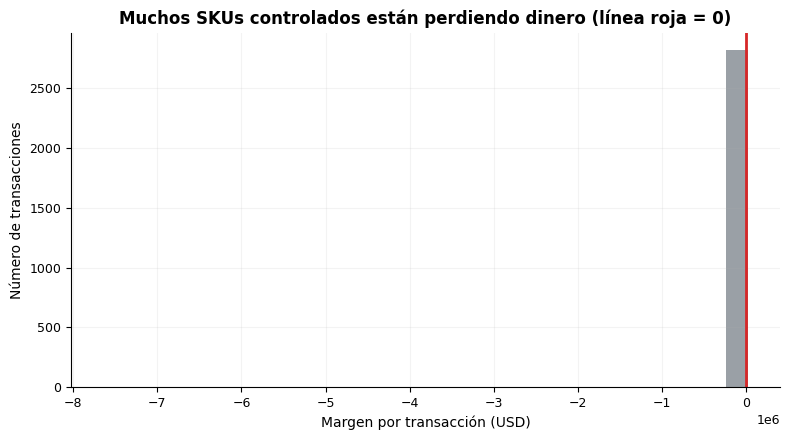

In [156]:
if "Margen_Utilidad" in controlados.columns:
    plt.figure()
    x = controlados["Margen_Utilidad"].dropna()
    plt.hist(x, bins=30, color=NEUTRAL)
    plt.axvline(0, linewidth=2, color=RISK)
    plt.title("Muchos SKUs controlados están perdiendo dinero (línea roja = 0)")
    plt.xlabel("Margen por transacción (USD)")
    plt.ylabel("Número de transacciones")
    plt.tight_layout()
    plt.show()



##### Ingreso por Categoría

¿De dónde viene el dinero?

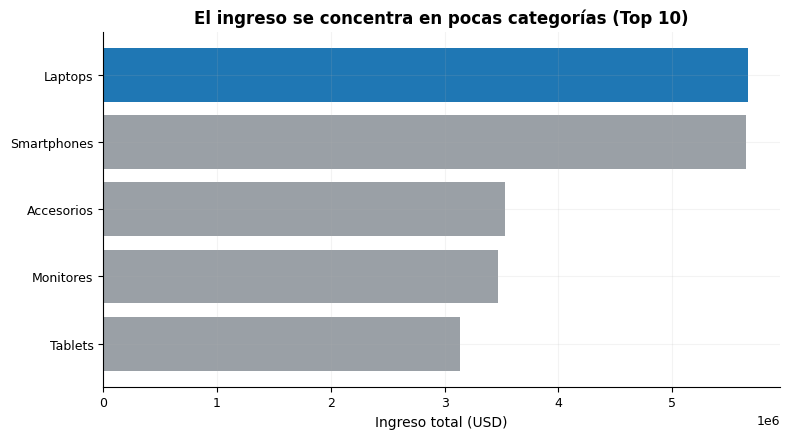

In [157]:
if {"Categoria", "Ingreso_Total"}.issubset(controlados.columns):
    top = (controlados.groupby("Categoria")["Ingreso_Total"]
           .sum()
           .sort_values(ascending=False)
           .head(10))
    barh_series(top, "El ingreso se concentra en pocas categorías (Top 10)", "Ingreso total (USD)")




##### Entregas tardías (proporción total)

¿Qué tan confiable es la logística?

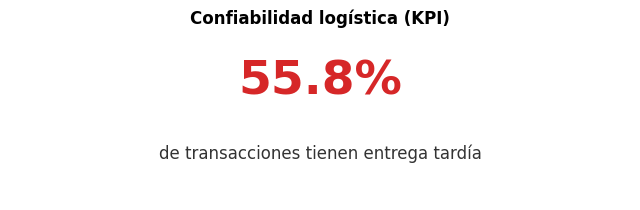

In [158]:
if "Entrega_Tardia" in df.columns:
    tasa = df["Entrega_Tardia"].mean() * 100
    kpi_tile(
        title="Confiabilidad logística (KPI)",
        value_text=f"{tasa:.1f}%",
        subtitle="de transacciones tienen entrega tardía",
        color=ACCENT if tasa < 20 else RISK
    )



#### Margen vs costo de envío (controlados)

¿El envío está comiéndose la rentabilidad?

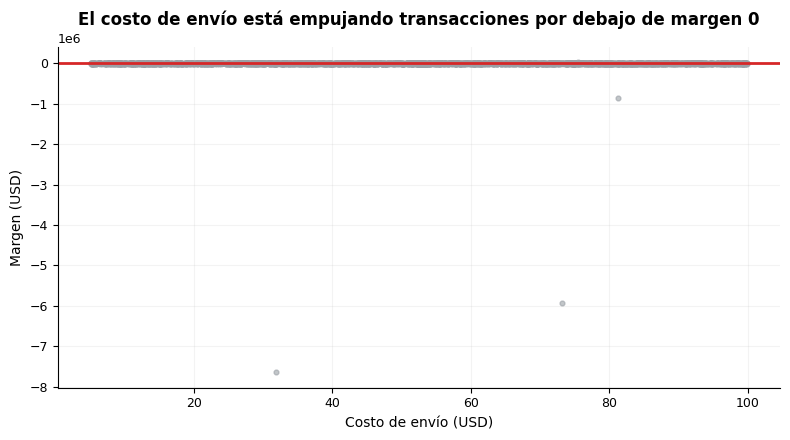

In [159]:
if {"Margen_Utilidad", "Costo_Envio"}.issubset(controlados.columns):
    plt.figure()
    plt.scatter(controlados["Costo_Envio"], controlados["Margen_Utilidad"], s=12, color=NEUTRAL, alpha=0.6)
    plt.axhline(0, linewidth=2, color=RISK)
    plt.title("El costo de envío está empujando transacciones por debajo de margen 0")
    plt.xlabel("Costo de envío (USD)")
    plt.ylabel("Margen (USD)")
    plt.tight_layout()
    plt.show()



#### Margen % por canal (controlados)

¿Qué canal vende rentable?

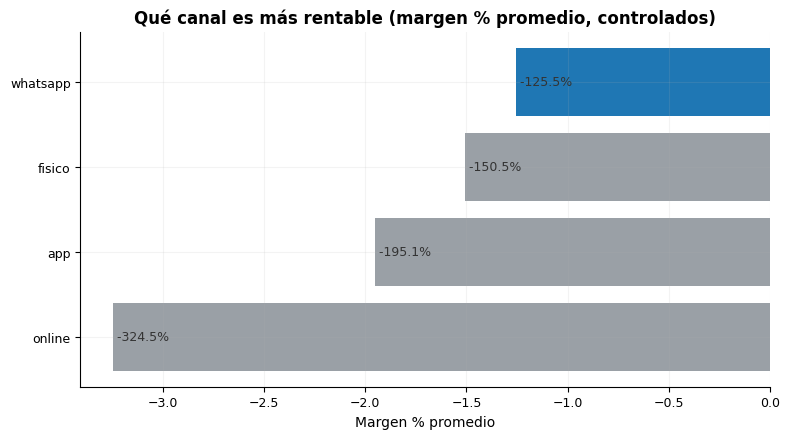

In [160]:
if {"Canal_Venta_norm", "Margen_%"}.issubset(controlados.columns):
    by = (controlados.groupby("Canal_Venta_norm")["Margen_%"]
          .mean()
          .sort_values(ascending=False))

    # Formateo a porcentaje
    barh_series(
        by.head(12),
        title="Qué canal es más rentable (margen % promedio, controlados)",
        xlabel="Margen % promedio",
        fmt=lambda x: f"{x*100:.1f}%"
    )


#### NPS vs entrega tardía (toda la operación o controlados)

¿Los retrasos bajan la satisfacción?

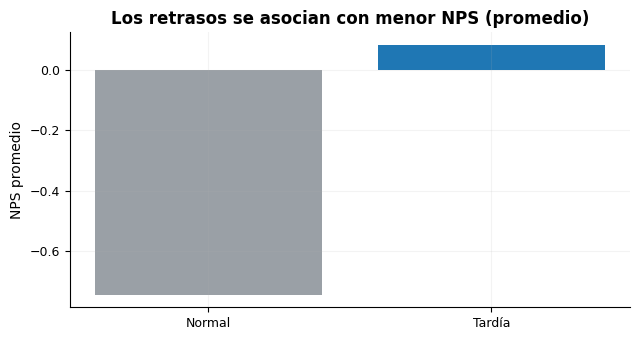

In [161]:
base = df.copy()
if {"Satisfaccion_NPS", "Entrega_Tardia"}.issubset(base.columns):
    grp = base.groupby("Entrega_Tardia")["Satisfaccion_NPS"].mean()

    # ordenar False (normal) primero, True (tardía) después si existen
    grp = grp.reindex([False, True]).dropna()

    fig, ax = plt.subplots(figsize=(6.5, 3.5))
    colors = [NEUTRAL, ACCENT][:len(grp)]
    ax.bar(["Normal", "Tardía"][:len(grp)], grp.values, color=colors)

    ax.set_title("Los retrasos se asocian con menor NPS (promedio)")
    ax.set_xlabel("")
    ax.set_ylabel("NPS promedio")
    plt.tight_layout()
    plt.show()



#### Riesgo por categoría (controlados)
¿Qué categorías concentran riesgo?

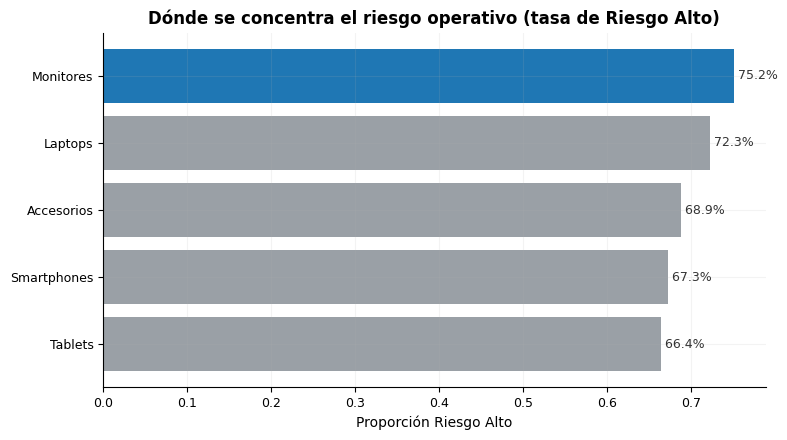

In [162]:
if {"Categoria", "Riesgo_Operacion"}.issubset(controlados.columns):
    vol = controlados["Categoria"].value_counts().head(10).index
    sub = controlados[controlados["Categoria"].isin(vol)].copy()

    risk_rate = (sub.assign(Riesgo_Alto=sub["Riesgo_Operacion"].eq("Alto"))
                   .groupby("Categoria")["Riesgo_Alto"].mean()
                   .sort_values(ascending=False))

    barh_series(
        risk_rate,
        title="Dónde se concentra el riesgo operativo (tasa de Riesgo Alto)",
        xlabel="Proporción Riesgo Alto",
        fmt=lambda x: f"{x*100:.1f}%"
    )



#### SKU fantasma: cuantificar el negocio fuera de control


SKU Fantasma: auditoría

Ingreso por canal (controlado vs fantasma):
es_fantasma            False       True 
Canal_Venta_norm                        
fisico            5229610.50  1459003.99
whatsapp          5487436.86  1417145.27
online            5291500.09  1267871.82
app               5429329.16  1176412.74


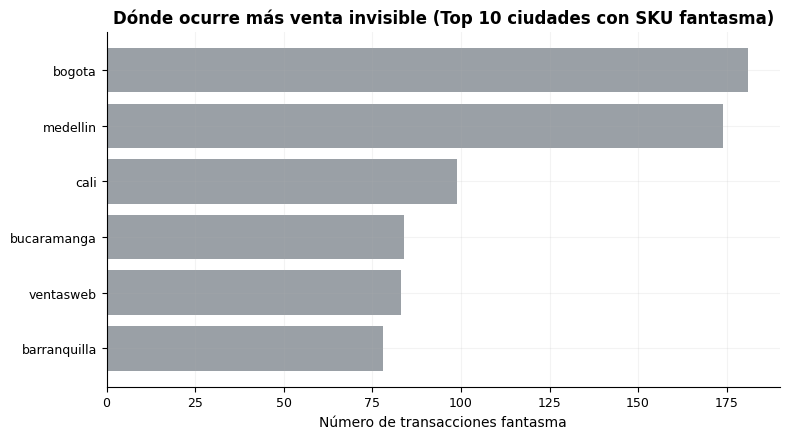

In [163]:
print("\nSKU Fantasma: auditoría")

# Ingreso fantasma por canal
if {"Canal_Venta_norm","Ingreso_Total"}.issubset(df.columns):
    tab = (df.assign(es_fantasma=df["SKU_Fantasma"])
             .groupby(["Canal_Venta_norm","es_fantasma"])["Ingreso_Total"]
             .sum()
             .unstack(fill_value=0))

    print("\nIngreso por canal (controlado vs fantasma):")
    print(tab.sort_values(by=True if True in tab.columns else tab.columns[-1], ascending=False).head(10))

# Conteo fantasma por ciudad (Top 10)
if {"Ciudad_Destino_norm", "SKU_Fantasma"}.issubset(df.columns):
    top_c = (df[df["SKU_Fantasma"] == True]["Ciudad_Destino_norm"]
             .value_counts()
             .head(10))

    barh_series(
        top_c,
        title="Dónde ocurre más venta invisible (Top 10 ciudades con SKU fantasma)",
        xlabel="Número de transacciones fantasma",
        highlight_last=False
    )


#### Fuga de Capital y Rentabilidad


SKUs con margen total negativo (Top 20)
         SKU_ID  Ventas  Unidades   Ingreso       Margen  Margen_%
322   PROD-1500       3      17.0  17391.55 -14432794.72   -829.87
1627  PROD-3432       5      51.0  41531.82    -34289.45     -0.83
1065  PROD-2609       5      49.0  24130.38    -33509.50     -1.39
603   PROD-1903       4      37.0   9459.87    -28701.94     -3.03
923   PROD-2383       3      29.0  13809.34    -26540.71     -1.92
1233  PROD-2858       2      20.0   1799.17    -23364.66    -12.99
710   PROD-2076       2      17.0   1922.60    -23357.55    -12.15
1071  PROD-2617       4      47.0  32198.53    -22278.37     -0.69
1292  PROD-2936       2      22.0   8425.56    -21861.08     -2.59
819   PROD-2233       4      32.0  15209.60    -21840.02     -1.44
1407  PROD-3110       2      25.0   9828.57    -20344.94     -2.07
1274  PROD-2908       3      33.0  28384.36    -19955.66     -0.70
903   PROD-2353       2      26.0   9715.03    -19074.06     -1.96
1269  PROD-2903      

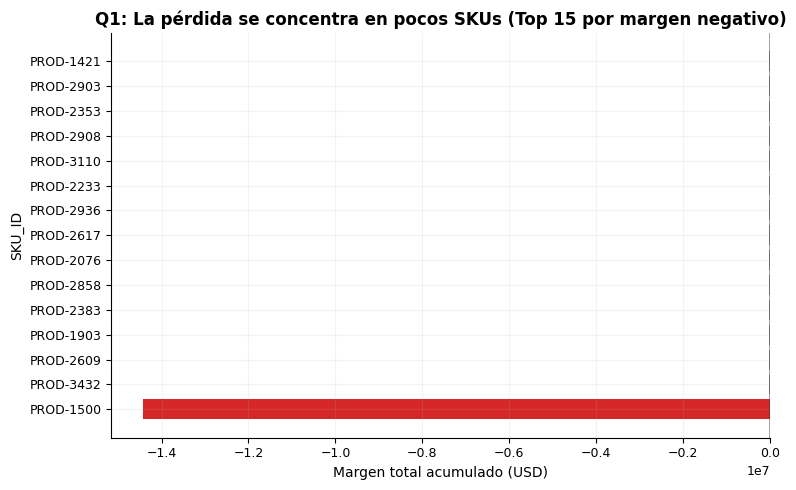

In [164]:
req_cols = ["SKU_ID", "Margen_Utilidad", "Ingreso_Total", "Cantidad_Vendida", "Canal_Venta_norm", "Transaccion_ID"]
missing = [c for c in req_cols if c not in controlados.columns]
if missing:
    print("No se puede ejecutar Q1. Faltan columnas:", missing)
else:
    base = controlados.dropna(subset=req_cols).copy()

    # KPI por SKU
    sku_kpi = (base.groupby("SKU_ID", as_index=False)
               .agg(
                   Ventas=("Transaccion_ID", "count"),
                   Unidades=("Cantidad_Vendida", "sum"),
                   Ingreso=("Ingreso_Total", "sum"),
                   Margen=("Margen_Utilidad", "sum")
               ))
    sku_kpi["Margen_%"] = np.where(sku_kpi["Ingreso"] > 0, sku_kpi["Margen"] / sku_kpi["Ingreso"], np.nan)

    # Top SKUs con mayor pérdida (margen total negativo)
    neg_skus = sku_kpi[sku_kpi["Margen"] < 0].sort_values("Margen")  # más pérdida primero

    print("\nSKUs con margen total negativo (Top 20)")
    print(neg_skus.head(20).round(2))

    # Peso del problema (económico)
    ingreso_ctrl = base["Ingreso_Total"].sum()
    ingreso_en_perdida = base.loc[base["Margen_Utilidad"] < 0, "Ingreso_Total"].sum()
    perdida_total = base.loc[base["Margen_Utilidad"] < 0, "Margen_Utilidad"].sum()

    print("\nIngreso controlado:", round(ingreso_ctrl, 2))
    if ingreso_ctrl > 0:
        print("Ingreso en ventas con margen negativo:", round(ingreso_en_perdida, 2),
              f"({100*ingreso_en_perdida/ingreso_ctrl:.2f}%)")
    else:
        print("Ingreso en ventas con margen negativo:", round(ingreso_en_perdida, 2), "(ingreso_ctrl=0)")

    print("Pérdida total (margen negativo acumulado):", round(perdida_total, 2))

    # --- Gráfico 1: Top 15 SKUs con mayor pérdida (mejor en horizontal) ---
    top_loss = neg_skus.head(15).set_index("SKU_ID")["Margen"]
    top_loss = top_loss.sort_values()  # deja peor abajo

    plt.figure(figsize=(8, 5))
    colors = [NEUTRAL] * len(top_loss)
    if len(colors) > 0:
        colors[0] = RISK  # el peor (más negativo)
    plt.barh(top_loss.index.astype(str), top_loss.values, color=colors)
    plt.axvline(0, linewidth=2, color="#333", alpha=0.5)
    plt.title("Q1: La pérdida se concentra en pocos SKUs (Top 15 por margen negativo)")
    plt.xlabel("Margen total acumulado (USD)")
    plt.ylabel("SKU_ID")
    plt.tight_layout()
    plt.show()


¿Online es crítico? % del ingreso en pérdidas por canal


Q1: % de ingreso asociado a transacciones con margen negativo (por canal)
                  Ingreso_Total  Ingreso_en_Perdida  %Ingreso_en_Perdida
Canal_Venta_norm                                                        
fisico               5229610.50          1130134.17               0.2161
whatsapp             5487436.86          1048084.76               0.1910
app                  5429329.16          1003275.97               0.1848
online               5291500.09           958632.09               0.1812


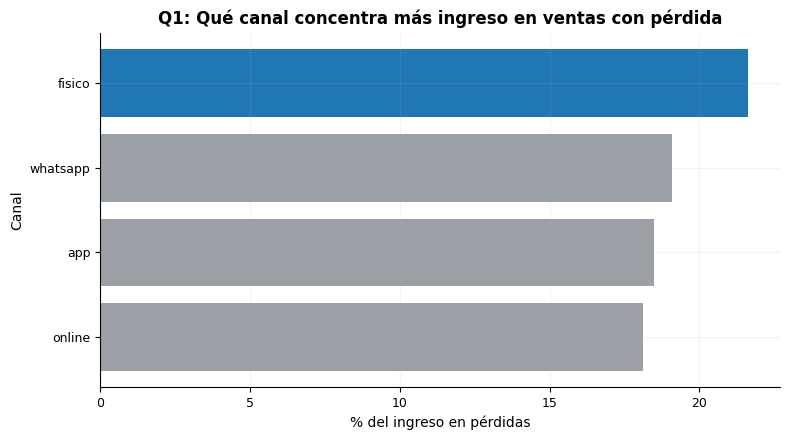

In [165]:
tmp = base.copy()
tmp["Perdida"] = tmp["Margen_Utilidad"] < 0

# Ingreso total y en pérdida por canal (sin hacks con lambda index)
ingreso_total_canal = tmp.groupby("Canal_Venta_norm")["Ingreso_Total"].sum()
ingreso_perdida_canal = tmp.loc[tmp["Perdida"]].groupby("Canal_Venta_norm")["Ingreso_Total"].sum()

by_channel = pd.DataFrame({
    "Ingreso_Total": ingreso_total_canal,
    "Ingreso_en_Perdida": ingreso_perdida_canal
}).fillna(0)

by_channel["%Ingreso_en_Perdida"] = np.where(
    by_channel["Ingreso_Total"] > 0,
    by_channel["Ingreso_en_Perdida"] / by_channel["Ingreso_Total"],
    np.nan
)

by_channel = by_channel.sort_values("%Ingreso_en_Perdida", ascending=False)

print("\nQ1: % de ingreso asociado a transacciones con margen negativo (por canal)")
print(by_channel.round(4))

# Gráfico 2: %Ingreso_en_Perdida por canal (horizontal, %)
plot_c = by_channel["%Ingreso_en_Perdida"].dropna().head(10)
plot_c = plot_c.sort_values(ascending=True)

plt.figure(figsize=(8, 4.5))
colors = [NEUTRAL] * len(plot_c)
if len(colors) > 0:
    colors[-1] = ACCENT  # el canal más crítico
plt.barh(plot_c.index.astype(str), plot_c.values * 100, color=colors)
plt.title("Q1: Qué canal concentra más ingreso en ventas con pérdida")
plt.xlabel("% del ingreso en pérdidas")
plt.ylabel("Canal")
plt.tight_layout()
plt.show()


¿Pérdida “aceptable por volumen”? Ingreso vs Margen por SKU (Top por ingreso)

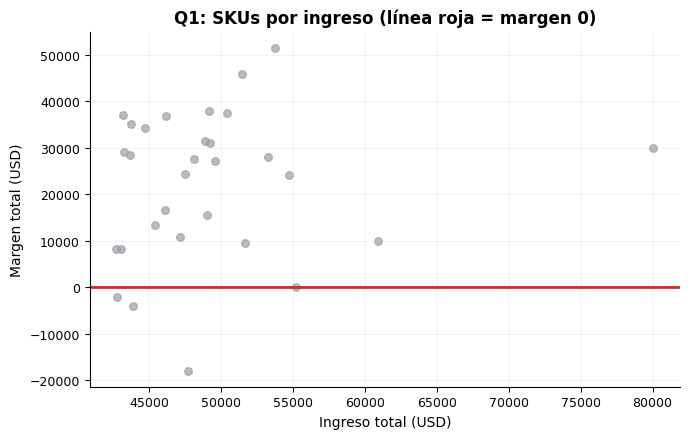

In [166]:
sku_full = (base.groupby("SKU_ID", as_index=False)
            .agg(Ingreso=("Ingreso_Total", "sum"),
                  Margen=("Margen_Utilidad", "sum")))
top_ing = sku_full.sort_values("Ingreso", ascending=False).head(30)

plt.figure(figsize=(7, 4.5))
plt.scatter(top_ing["Ingreso"], top_ing["Margen"], s=30, color=NEUTRAL, alpha=0.7)
plt.axhline(0, linewidth=2, color=RISK)
plt.title("Q1: SKUs por ingreso (línea roja = margen 0)")
plt.xlabel("Ingreso total (USD)")
plt.ylabel("Margen total (USD)")
plt.tight_layout()
plt.show()


#### Crisis Logística y Cuellos de Botella

Top ciudades por correlación (Tiempo Entrega → NPS bajo)


Q2: Top ciudades por correlación (n>=50)
                       n  tiempo_prom  tasa_nps_bajo  corr_tiempo_vs_nps_bajo
Ciudad_Destino_norm                                                          
cali                 443      13.7025         0.4853                   0.0413
bogota               911      14.9031         0.4797                   0.0228
ventasweb            482      15.6033         0.5311                  -0.0031
bucaramanga          415      15.2289         0.4988                  -0.0094
barranquilla         421      15.4252         0.5297                  -0.0204
medellin             853      15.1168         0.5135                  -0.0225


/tmp/ipython-input-480733166.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  city_stats["corr_tiempo_vs_nps_bajo"] = log_base.groupby("Ciudad_Destino_norm").apply(corr_time_vs_npslow)


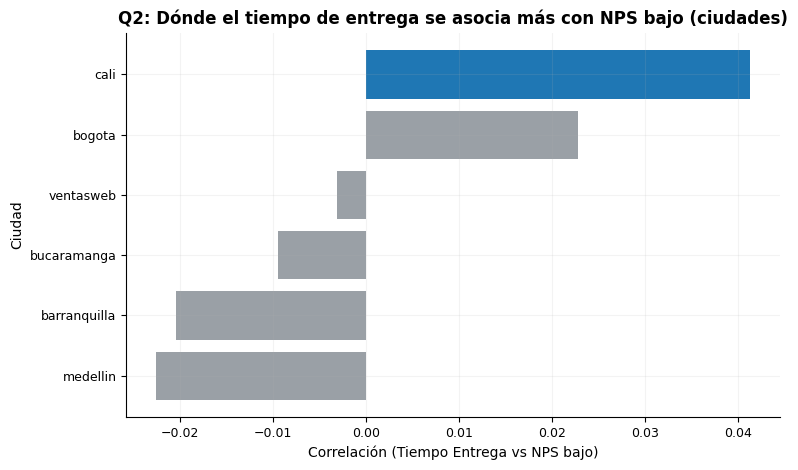

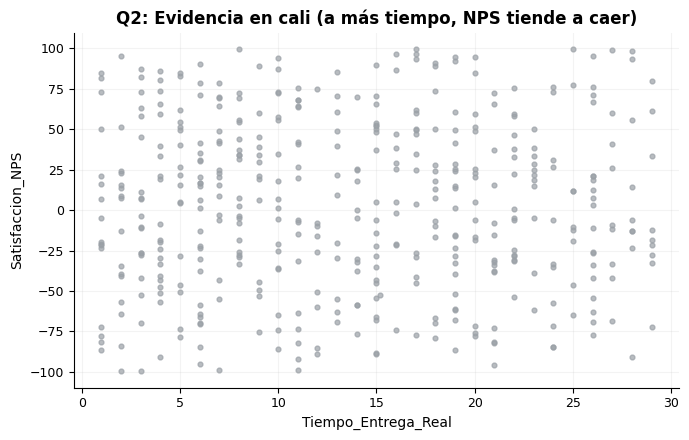


Q2: Top bodegas por correlación (n>=50, controlados)
                 n  tiempo_prom  tasa_nps_bajo  corr_tiempo_vs_nps_bajo
Bodega_Origen                                                          
Occidente      456      14.4851         0.5373                   0.0233
Zona Franca    456      15.0607         0.5110                   0.0151
Norte          945      14.9837         0.5048                   0.0066
Externa        470      15.2532         0.4681                  -0.0038
Sur            499      15.0178         0.5030                  -0.0268


/tmp/ipython-input-480733166.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bod_stats["corr_tiempo_vs_nps_bajo"] = bod_base.groupby("Bodega_Origen").apply(corr_time_vs_npslow)


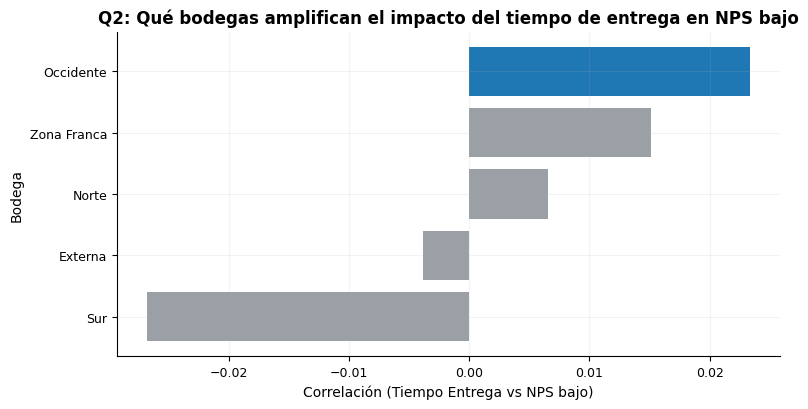

In [167]:
req_log_cols = ["Tiempo_Entrega_Real", "Satisfaccion_NPS", "Transaccion_ID"]
missing = [c for c in req_log_cols if c not in df.columns]
if missing:
    print("No se puede ejecutar Q2. Faltan columnas:", missing)
else:
    # Base logística general por ciudad
    if "Ciudad_Destino_norm" in df.columns:
        log_base = df.dropna(subset=["Tiempo_Entrega_Real", "Satisfaccion_NPS", "Ciudad_Destino_norm", "Transaccion_ID"]).copy()
        log_base["NPS_bajo"] = (log_base["Satisfaccion_NPS"] <= 0).astype(int)

        def corr_time_vs_npslow(g):
            # correlación Pearson entre tiempo y NPS_bajo (0/1)
            return g["Tiempo_Entrega_Real"].corr(g["NPS_bajo"])

        city_stats = (log_base.groupby("Ciudad_Destino_norm")
                      .agg(n=("Transaccion_ID", "count"),
                           tiempo_prom=("Tiempo_Entrega_Real", "mean"),
                           tasa_nps_bajo=("NPS_bajo", "mean")))
        city_stats["corr_tiempo_vs_nps_bajo"] = log_base.groupby("Ciudad_Destino_norm").apply(corr_time_vs_npslow)

        # filtro de robustez
        city_stats = city_stats[city_stats["n"] >= 50].sort_values("corr_tiempo_vs_nps_bajo", ascending=False)

        print("\nQ2: Top ciudades por correlación (n>=50)")
        print(city_stats.head(15).round(4))

        # Gráfico: Top 12 ciudades por correlación (horizontal)
        top_city = city_stats.head(12)["corr_tiempo_vs_nps_bajo"].sort_values(ascending=True)
        plt.figure(figsize=(8, 4.8))
        colors = [NEUTRAL] * len(top_city)
        if len(colors) > 0:
            colors[-1] = ACCENT
        plt.barh(top_city.index.astype(str), top_city.values, color=colors)
        plt.title("Q2: Dónde el tiempo de entrega se asocia más con NPS bajo (ciudades)")
        plt.xlabel("Correlación (Tiempo Entrega vs NPS bajo)")
        plt.ylabel("Ciudad")
        plt.tight_layout()
        plt.show()

        # Evidencia “zona crítica”: usar score = corr * tasa_nps_bajo
        crit = city_stats.copy()
        crit["score"] = crit["corr_tiempo_vs_nps_bajo"].fillna(0) * crit["tasa_nps_bajo"].fillna(0)
        worst_city = crit.sort_values("score", ascending=False).index[0]

        sub = log_base[log_base["Ciudad_Destino_norm"] == worst_city]
        plt.figure(figsize=(7, 4.5))
        plt.scatter(sub["Tiempo_Entrega_Real"], sub["Satisfaccion_NPS"], s=12, color=NEUTRAL, alpha=0.7)
        plt.title(f"Q2: Evidencia en {worst_city} (a más tiempo, NPS tiende a caer)")
        plt.xlabel("Tiempo_Entrega_Real")
        plt.ylabel("Satisfaccion_NPS")
        plt.tight_layout()
        plt.show()

    # Base logística controlada por bodega
    if "Bodega_Origen" in controlados.columns:
        bod_base = controlados.dropna(subset=["Tiempo_Entrega_Real", "Satisfaccion_NPS", "Bodega_Origen", "Transaccion_ID"]).copy()
        bod_base["NPS_bajo"] = (bod_base["Satisfaccion_NPS"] <= 0).astype(int)

        def corr_time_vs_npslow(g):
            return g["Tiempo_Entrega_Real"].corr(g["NPS_bajo"])

        bod_stats = (bod_base.groupby("Bodega_Origen")
                     .agg(n=("Transaccion_ID", "count"),
                          tiempo_prom=("Tiempo_Entrega_Real", "mean"),
                          tasa_nps_bajo=("NPS_bajo", "mean")))
        bod_stats["corr_tiempo_vs_nps_bajo"] = bod_base.groupby("Bodega_Origen").apply(corr_time_vs_npslow)

        bod_stats = bod_stats[bod_stats["n"] >= 50].sort_values("corr_tiempo_vs_nps_bajo", ascending=False)

        print("\nQ2: Top bodegas por correlación (n>=50, controlados)")
        print(bod_stats.head(10).round(4))

        top_bod = bod_stats.head(10)["corr_tiempo_vs_nps_bajo"].sort_values(ascending=True)
        plt.figure(figsize=(8, 4.2))
        colors = [NEUTRAL] * len(top_bod)
        if len(colors) > 0:
            colors[-1] = ACCENT
        plt.barh(top_bod.index.astype(str), top_bod.values, color=colors)
        plt.title("Q2: Qué bodegas amplifican el impacto del tiempo de entrega en NPS bajo")
        plt.xlabel("Correlación (Tiempo Entrega vs NPS bajo)")
        plt.ylabel("Bodega")
        plt.tight_layout()
        plt.show()


Top bodegas por correlación (Tiempo Entrega → NPS bajo)

Evidencia visual para la “zona crítica” (scatter)

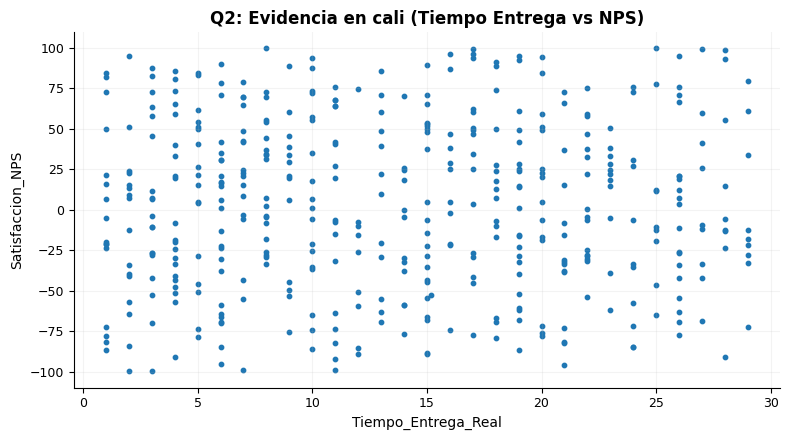

In [168]:
crit = city_stats.copy()
crit["score"] = crit["corr_tiempo_vs_nps_bajo"].fillna(0) * crit["tasa_nps_bajo"].fillna(0)
worst_city = crit.sort_values("score", ascending=False).index[0]

sub = log_base[log_base["Ciudad_Destino_norm"] == worst_city]

plt.figure()
plt.scatter(sub["Tiempo_Entrega_Real"], sub["Satisfaccion_NPS"], s=10)
plt.title(f"Q2: Evidencia en {worst_city} (Tiempo Entrega vs NPS)")
plt.xlabel("Tiempo_Entrega_Real")
plt.ylabel("Satisfaccion_NPS")
plt.tight_layout()
plt.show()


#### Análisis de la Venta Invisible

¿Cuánto ingreso está en riesgo por SKUs fuera del inventario?


Q3: Venta Invisible (SKU fantasma)
Ingreso total: 26758310.43
Ingreso SKU fantasma: 5320433.82
% del ingreso total en riesgo (sin control de inventario): 19.88 %


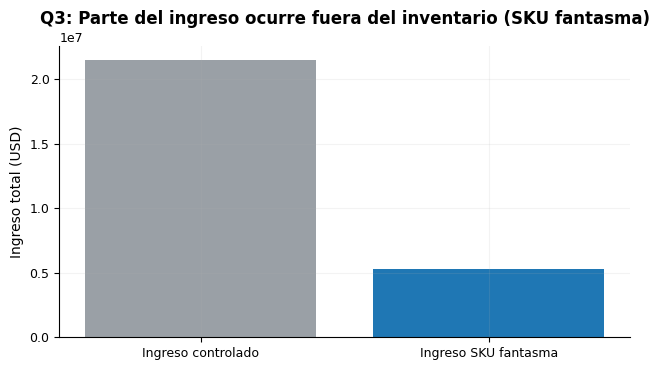

In [169]:
if {"Ingreso_Total", "SKU_Fantasma"}.issubset(df.columns):
    total_ingreso = df["Ingreso_Total"].sum()

    # CORRECCIÓN: fantasmas_df debe ser DataFrame, no un entero
    fantasmas_df = df[df["SKU_Fantasma"] == True].copy()
    ingreso_fantasma = fantasmas_df["Ingreso_Total"].sum()

    pct_riesgo = ingreso_fantasma / total_ingreso if total_ingreso > 0 else np.nan

    print("\nQ3: Venta Invisible (SKU fantasma)")
    print("Ingreso total:", round(total_ingreso, 2))
    print("Ingreso SKU fantasma:", round(ingreso_fantasma, 2))
    print("% del ingreso total en riesgo (sin control de inventario):", round(100*pct_riesgo, 2), "%")

    # Gráfico simple con énfasis
    labels = ["Ingreso controlado", "Ingreso SKU fantasma"]
    values = [df.loc[df["SKU_Fantasma"] == False, "Ingreso_Total"].sum(), ingreso_fantasma]

    plt.figure(figsize=(6.5, 3.8))
    plt.bar(labels, values, color=[NEUTRAL, ACCENT])
    plt.title("Q3: Parte del ingreso ocurre fuera del inventario (SKU fantasma)")
    plt.ylabel("Ingreso total (USD)")
    plt.tight_layout()
    plt.show()
else:
    print("No se puede ejecutar Q3. Faltan columnas Ingreso_Total o SKU_Fantasma.")

#### Storytelling de Riesgo Operativo

Historia principal: tasa de tickets por “edad” (bins) + volumen por bin


Q5: Tasa de tickets por antigüedad de revisión
  Edad_Bin     n  tasa_tickets
0     0-30   153      0.483660
1    31-60   120      0.616667
2    61-90   133      0.571429
3   91-180   332      0.578313
4  181-365   747      0.583668
5     365+  1341      0.557047
Correlación (edad revisión vs tickets): -0.0152


/tmp/ipython-input-2747584429.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = (risk.groupby("Edad_Bin", as_index=False)


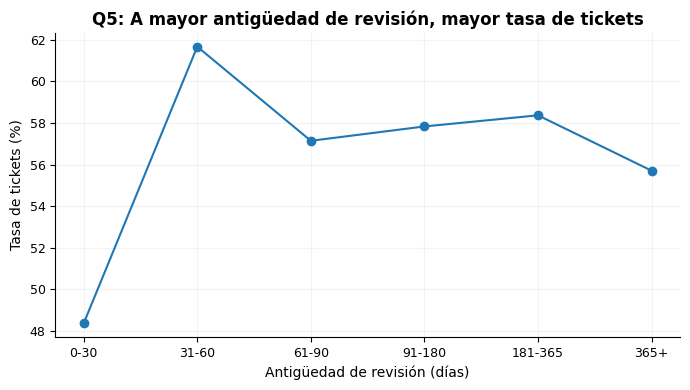

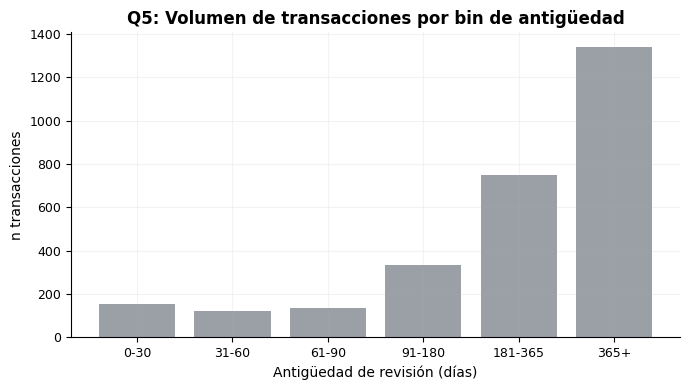

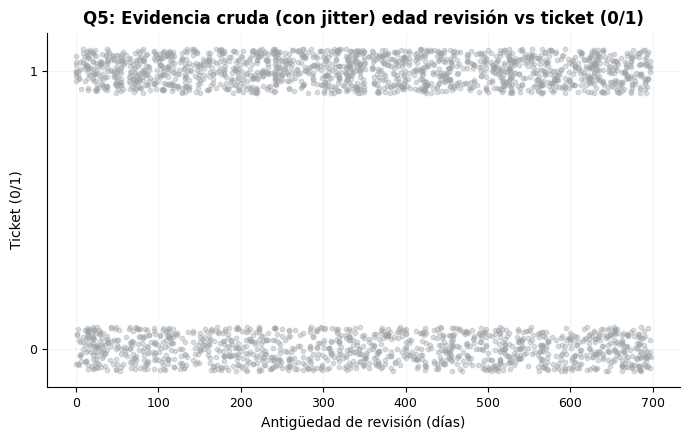

In [170]:
need_q5 = ["Ultima_Revision_dt", "Ticket_Indicador", "Transaccion_ID"]
missing = [c for c in need_q5 if c not in controlados.columns]
if missing:
    print("No se puede ejecutar Q5. Faltan columnas:", missing)
else:
    risk = controlados.dropna(subset=need_q5).copy()

    # Fecha de referencia: última venta observada (más consistente)
    ref_date = df["Fecha_Venta_dt"].max() if "Fecha_Venta_dt" in df.columns else pd.NaT
    if pd.isna(ref_date):
        ref_date = df["Ultima_Revision_dt"].max() if "Ultima_Revision_dt" in df.columns else pd.NaT

    risk["Antiguedad_Revision_Dias"] = (ref_date - risk["Ultima_Revision_dt"]).dt.days
    risk = risk[(risk["Antiguedad_Revision_Dias"].notna()) & (risk["Antiguedad_Revision_Dias"] >= 0)]

    bins = [0, 30, 60, 90, 180, 365, 10_000]
    labels = ["0-30", "31-60", "61-90", "91-180", "181-365", "365+"]

    risk["Edad_Bin"] = pd.cut(risk["Antiguedad_Revision_Dias"], bins=bins, labels=labels, include_lowest=True)

    bin_stats = (risk.groupby("Edad_Bin", as_index=False)
                 .agg(n=("Transaccion_ID", "count"),
                      tasa_tickets=("Ticket_Indicador", "mean")))

    print("\nQ5: Tasa de tickets por antigüedad de revisión")
    print(bin_stats)

    corr = risk["Antiguedad_Revision_Dias"].corr(risk["Ticket_Indicador"])
    print("Correlación (edad revisión vs tickets):", round(corr, 4))

    # Línea: tasa tickets por bin (énfasis)
    plt.figure(figsize=(7, 4))
    plt.plot(bin_stats["Edad_Bin"].astype(str), bin_stats["tasa_tickets"]*100, marker="o", color=ACCENT)
    plt.title("Q5: A mayor antigüedad de revisión, mayor tasa de tickets")
    plt.xlabel("Antigüedad de revisión (días)")
    plt.ylabel("Tasa de tickets (%)")
    plt.tight_layout()
    plt.show()

    # Barras: volumen por bin (contexto)
    plt.figure(figsize=(7, 4))
    plt.bar(bin_stats["Edad_Bin"].astype(str), bin_stats["n"], color=NEUTRAL)
    plt.title("Q5: Volumen de transacciones por bin de antigüedad")
    plt.xlabel("Antigüedad de revisión (días)")
    plt.ylabel("n transacciones")
    plt.tight_layout()
    plt.show()

    # Evidencia cruda: mejor con jitter vertical para no “pegarse” en 0/1
    y = risk["Ticket_Indicador"] + np.random.uniform(-0.08, 0.08, size=len(risk))
    plt.figure(figsize=(7, 4.5))
    plt.scatter(risk["Antiguedad_Revision_Dias"], y, s=10, color=NEUTRAL, alpha=0.35)
    plt.title("Q5: Evidencia cruda (con jitter) edad revisión vs ticket (0/1)")
    plt.xlabel("Antigüedad de revisión (días)")
    plt.ylabel("Ticket (0/1)")
    plt.yticks([0, 1], ["0", "1"])
    plt.tight_layout()
    plt.show()